In [2]:
import matplotlib.pyplot as plt
from numba import njit
from numba.typed import List
import numpy as np
from scipy.optimize import curve_fit

In [3]:
Id = np.array([[1., 0.],
               [0., 1.]])

Z = np.array([[1., 0.],
              [0., -1.]])

X = np.array([[0., 1.],
              [1., 0.]])

@njit
def tp(A):
    prod = np.kron(A[0], A[1])
    for a in A[2:]:
        prod = np.kron(prod, a)
    return prod


tp(List([Id, Id, Id]));

In [4]:
def Ha(ns, W=None, A=50):
    # ns := # of squares in the graph
    N = 4 + 3*(ns - 1)
    
    IdN = np.eye(2**N)
    s_z = [tp(List((i)*[Id] + [Z] + (N-i-1)*[Id])) for i in range(N)]

    Hs = A/4 * (2*IdN + 2*s_z[0].dot(s_z[ns]))
    Ht = A/4 * (2*IdN + 2*s_z[N-1].dot(s_z[2*ns]))
    
    Hij = np.zeros(IdN.shape)
    
    # source and tagert horizontal edges
    Hij += IdN - s_z[0].dot(s_z[1] + s_z[ns+1]) - 2*s_z[0]
    Hij += IdN - s_z[N-1].dot(s_z[2*ns-1] + s_z[N-2]) - 2*s_z[N-1]

    # horizontal corner edges
    Hij += 2*IdN + s_z[ns-1].dot(s_z[2*ns-1] - s_z[ns-2] - s_z[2*ns]) + 2*s_z[ns-1]
    Hij += 2*IdN + s_z[2*ns+1].dot(s_z[ns+1] - s_z[2*ns+2] - s_z[ns]) + 2*s_z[2*ns+1]
    # vertical corner edges
    Hij += IdN - s_z[ns].dot(s_z[2*ns+1])
    Hij += IdN - s_z[2*ns].dot(s_z[ns-1])
    
    # lower horizontal internal edges
    for i in range(1, ns-1):
        Hij += 2*IdN + s_z[i].dot(s_z[i+ns] - s_z[i-1] - s_z[i+ns+1] - s_z[i+1])
    # vertical internal edges
    for i in range(ns+1, 2*ns):
        Hij += 4*IdN + s_z[i].dot(s_z[i-ns] + s_z[i+ns] - s_z[i-ns-1] - s_z[i+ns+1]) + 4*s_z[i]
    # higher horizontal internal edges
    for i in range(2*ns+2, N-1):
        Hij += 2*IdN + s_z[i].dot(s_z[i-ns] - s_z[i-1] - s_z[i-ns-1] - s_z[i+1])

    Hij = A/4 * Hij
    
    HA = Hs + Ht + Hij
    
    return HA


def Hb(ns, W, B=1):
    N = 4 + 3*(ns - 1)

    IdN = np.eye(2**N)
    s_z = [tp(List((i)*[Id] + [Z] + (N-i-1)*[Id])) for i in range(N)]

    HB = np.zeros(IdN.shape)
    for w, sigma in zip(W, s_z):
        HB += B / 2 * w * sigma
    HB += B / 2 * np.sum(W) * IdN
    
    return HB


def H0(ns):
    N = 4 + (ns - 1)*3
    
    s_x = [tp(List((i)*[Id] + [X] + (N-i-1)*[Id])) for i in range(N)]
    
    H = np.zeros(s_x[0].shape)
    for j in range(N):
        H += -s_x[j]
    
    return H

In [328]:
ns = 1
N = 4

A = 50
B = 1
    
IdN = tp(List([Id for i in range(N)]))
s_z = [tp(List((i)*[Id] + [Z] + (N-i-1)*[Id])) for i in range(N)]

Hs = A/4 * (2*IdN + 2*s_z[0].dot(s_z[ns]))
Ht = A/4 * (2*IdN + 2*s_z[N-1].dot(s_z[N-1-ns]))

Hij = A/4 * (2*IdN - 2 * s_z[0].dot(s_z[2]))
Hij += A/4 * (2*IdN - 2 * s_z[1].dot(s_z[3]))

HA1 = Hs + Ht + Hij

In [339]:
W = np.random.random(4)

In [364]:
n = 1001
ns = 1

S = np.linspace(0, 0.2, n)
E_app = np.zeros((n, 2))
E = np.zeros((n, 2))

Hx = H0(ns)
HB = Hb(ns, W)
Hp = HB + HA1
for l, s in enumerate(S):

    H = np.zeros((N+1, N+1))
    for i in range(N+1):
        for j in range(i, N+1):
            if i == j:
                H[i, j] = 2*(1 - s)
            elif i == 0:
                H[i, j] = s*W[j-1]/2

    H[0, 0] = 0
    H[1, 2] = +s * A/2
    H[1, 3] = -s * A/2
    H[2, 4] = -s * A/2
    H[3, 4] = +s * A/2

    E_app[l, :] = np.linalg.eigh(H, 'U')[0][:2]
    if s == 0.1:
        print(H)
    
    H = (1 - s)*Hx + s*Hp
    E[l, :] = np.linalg.eigh(H, 'U')[0][:2]

[[ 0.          0.0259961   0.0440767   0.00333654  0.00288953]
 [ 0.          1.8         2.5        -2.5         0.        ]
 [ 0.          0.          1.8         0.         -2.5       ]
 [ 0.          0.          0.          1.8         2.5       ]
 [ 0.          0.          0.          0.          1.8       ]]


In [363]:
e, v = np.linalg.eigh(Hp)
Df = e[1] - e[0]

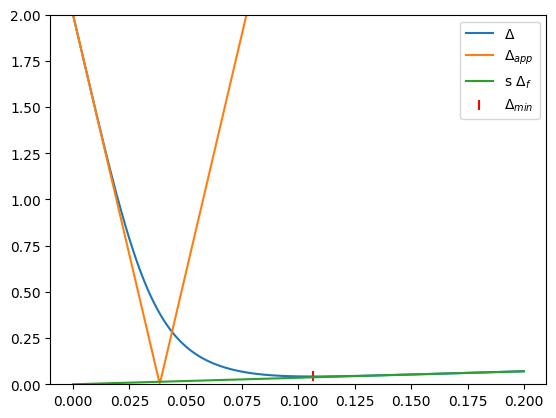

In [349]:
# DE = 3/2 * A
# w = np.mean(W)
# Ds = np.sqrt((2*(1 - S) - S * DE)**2 + 4 * S**2 * w**2)

dE = E[:, 1] - E[:, 0]
dE_app = E_app[:, 1] - E_app[:, 0]
plt.plot(S, dE, label="$\Delta$")
plt.plot(S, dE_app, label="$\Delta_{{app}}$")
# plt.plot(S, Ds)
plt.plot(S, Df*S, label="s $\Delta_f$")
plt.scatter(S[np.argmin(dE)], min(dE), s=50, marker="|", c='r', label="$\Delta_{{min}}$")
plt.ylim([0, 2])
plt.legend();

In [350]:
popt, pcov = curve_fit(lambda x, a: a*x + 2, S[:np.argmin(dE_app)], dE_app[:np.argmin(dE_app)], p0=[-1])
popt

array([-51.99347718])

In [264]:
S[np.argmin(Df*S + (1-S)**2 / S * E2)]

/var/folders/5g/2335ntzx51d49vw09x7__6t40000gn/T/ipykernel_6178/3968969856.py:1: RuntimeWarning: divide by zero encountered in divide
  S[np.argmin(Df*S + (1-S)**2 / S * E2)]


0.014214214214214215

In [286]:
(Df*S + (1-S)**2 / S * E2)[np.argmin(dE)]

/var/folders/5g/2335ntzx51d49vw09x7__6t40000gn/T/ipykernel_6178/2403019841.py:1: RuntimeWarning: divide by zero encountered in divide
  (Df*S + (1-S)**2 / S * E2)[np.argmin(dE)]


0.4761131202218118

In [ ]:
Df*S

In [255]:
Df*S[np.argmin(np.abs(Df*S - (E_app[:, 1] - E_app[:, 0])))]

0.007987094123829948

In [156]:
min(dE)

0.09970314858330837

In [158]:
S[np.argmin(dE)]*Df

0.08864624182263138

In [ ]:
ns = 5
N = 4 + 3*(ns - 1)

s_z = [tp(List((i)*[Id] + [Z] + (N-i-1)*[Id])) for i in range(N)]

HA = Ha(ns)
HB = Hb(ns, W=np.arange(1, N+1))
E, v = np.linalg.eigh(HA + HB)

for n in range(5):
    rep = list()
    for i in range(N):
        rep.append(v[:, n].dot(s_z[i].dot(v[:, n])))
    
    rep = map(lambda x: '0' if x == -1 else '1', rep)
    print(f'E = {E[n]:6.2f};', end='  ')
#     print(int(v[:, n].dot(Hs.dot(v[:, n]))), end=' ')
#     print(int(v[:, n].dot(Ht.dot(v[:, n]))), end=' ')
#     print(int(v[:, n].dot(Hij.dot(v[:, n]))), end=' ')
    print(' '.join(rep), end='  ')
    print()

In [6]:
n = 101
S = np.linspace(0, 0.2, n)

avg_steps = 100

ns_max = 4
Sc = np.zeros(ns_max)
Dmin = np.zeros(ns_max)
for ns in range(1, ns_max + 1):
    N = 4 + 3*(ns - 1)
    E = np.zeros((n, 4))
    
    if ns != 1:
        HA = Ha(ns)
    else:
        HA = np.copy(HA1)

    Hint = H0(ns)

    for i, s in enumerate(S):
        
        Ew = np.zeros((avg_steps, 4))
        for j in range(avg_steps):
            W = np.random.random(N)
            HB = Hb(ns, W=W)
            
            H = (1-s)*Hint + s*(HA + HB)

            Ew[j] = np.linalg.eigvalsh(H)[:4]
        
        E[i] = np.mean(Ew, axis=0)
    
    Sc[ns - 1] = S[np.argmin(np.abs(E[:, 1] - E[:, 0]))]
    Dmin[ns - 1] = np.min(np.abs(E[:, 1] - E[:, 0]))
    S = np.linspace(0, S[np.argmin(np.abs(E[:, 1] - E[:, 0])) + 1], n)

KeyboardInterrupt: 

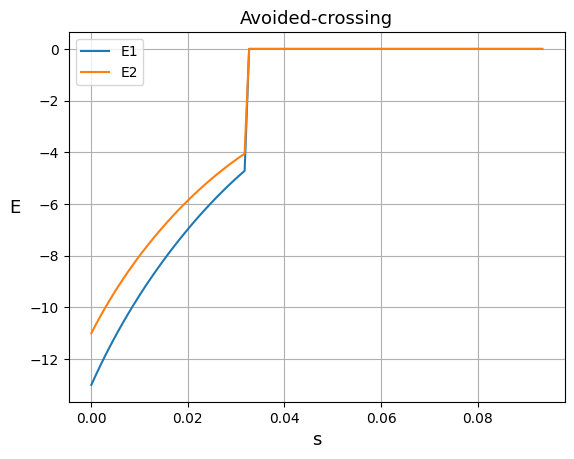

In [7]:
plt.plot(S, E[:, 0], label='E1')
plt.plot(S, E[:, 1], label='E2')

plt.xlabel('s', fontsize=13)
plt.ylabel('E   ', fontsize=13, rotation='horizontal')
plt.title('Avoided-crossing', fontsize=13)
plt.legend()
plt.grid()

In [10]:
%%time

HB = Hb(ns, W=W)
            
H = (1-s)*Hint + s*(HA + HB)

Ew[j] = np.linalg.eigvalsh(H)[:4]

CPU times: user 6min 13s, sys: 6.42 s, total: 6min 20s
Wall time: 1min 1s


In [ ]:
lambda_c = (1 - Sc) / Sc

power_fit = lambda x, a, b, c: a*x**b + c
# log_fit = lambda x, a, b, c: a * np.log(x + b) + c

x_ = np.arange(1, ns_max+1)*2 + 1
x = np.linspace(1, ns_max)*2 + 1

plt.scatter(x_, lambda_c, label='data', s=20)

popt, pcov = curve_fit(power_fit, x_, lambda_c, maxfev=5000)
plt.plot(x, power_fit(x, *popt), label='$a x^b + c$ ', c='tab:orange')
print(popt)

# popt, pcov = curve_fit(log_fit, x_, lambda_c, maxfev=10000)
# plt.plot(x, log_fit(x, *popt), label='$a\\ \\log(N + b) + c $', c='tab:green')
# print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$\\lambda_{c}$   ', fontsize=14, rotation='horizontal')
plt.title('Critical lambda scaling', fontsize=14)
plt.legend()
plt.grid()

In [ ]:
power_fit = lambda x, a, b, c: a * x**b + c
# log_fit = lambda x, a, b, c: a * np.log(x + b) + c

x_ = np.arange(1, ns_max+1)*2 + 1
x = np.linspace(1, ns_max)*2 + 1

plt.scatter(x_, Dmin, label='data', s=20)

popt, pcov = curve_fit(power_fit, x_, Dmin, maxfev=5000)
plt.plot(x, power_fit(x, *popt), label='$a x^b + c$ ', c='tab:orange')
print(popt)

# popt, pcov = curve_fit(log_fit, x_[1:], Dmin[1:], maxfev=5000)
# plt.plot(x, log_fit(x, *popt), label='log', c='tab:green')
# print(popt)

plt.xlabel('N', fontsize=14)
plt.ylabel('$\\Delta_{min}$         ', fontsize=14, rotation='horizontal')
plt.legend()
plt.grid()

In [14]:
[2*i*(i+1) for i in range(10)]

[0, 4, 12, 24, 40, 60, 84, 112, 144, 180]